# Data Exploration and Preprocessing 

This data exploration will aim to yield an introductory understanding of the Santander Value Prediction dataset.

## Load Libraries:

In [0]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.pyplot as plt
import seaborn as sns

import os
import pdb
import h5py

from sklearn.decomposition import PCA

## Load the Data:

In [0]:
train_df = pd.read_csv('/content/train.csv.zip', index_col='ID')
test_df = pd.read_csv('/content/test.csv.zip', index_col='ID')

In [6]:
print('Shape of train dataframe: {} Rows, {} Columns'.format(*train_df.shape))
print('Shape of test dataframe: {} Rows, {} Columns'.format(*test_df.shape))

Shape of train dataframe: 4459 Rows, 4992 Columns
Shape of test dataframe: 49342 Rows, 4991 Columns


In [0]:
# Separate the training labels
labels = train_df.target
train_df.drop(columns=['target'], inplace=True)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4459 entries, 000d6aaf2 to ffeb15d25
Columns: 4991 entries, 48df886f9 to 9fc776466
dtypes: float64(1844), int64(3147)
memory usage: 169.8+ MB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49342 entries, 000137c73 to fffbe2f6f
Columns: 4991 entries, 48df886f9 to 9fc776466
dtypes: float64(4991)
memory usage: 1.8+ GB


## Dataset Exploration:

In [10]:
# Find number of null values 
print ('Number of null values in training set:', train_df.isnull().sum().sum())
print ('Number of null values in test set:', test_df.isnull().sum().sum())

Number of null values in training set: 0
Number of null values in test set: 0


In [0]:
# Find sparsity of dataset
def how_sparse(df):
    num_nonzero = df.astype(bool).sum(axis=0).sum()
    return(100 * num_nonzero/float(df.shape[0] * df.shape[1]))

In [12]:
print ('Sparsity of training data (in percent):', how_sparse(train_df))
print ('Sparsity of test data (in percent):', how_sparse(test_df))

Sparsity of training data (in percent): 3.1458688882868735
Sparsity of test data (in percent): 1.4052106649169267


In [0]:
# How many columns have constant values? 
def is_constant(df):
    constant = []
    for column in df.columns.values:
        if len(df[column].unique()) == 1:
            constant.append(column)
    return(constant)

In [14]:
print ('Number of columns with constant values in train dataset:', len(is_constant(train_df)))
print ('Number of columns with constant values in test dataset:', len(is_constant(test_df)))

Number of columns with constant values in train dataset: 256
Number of columns with constant values in test dataset: 0


Interestingly, there are 256 columns in the training dataset that have constant values while there are 0 columns in the test dataset. This behavior is most likely due to the test dataset having almost 10x more samples than the training dataset. During the data preprocessing stage, the 256 columns with constant values will need to be removed from both the training and test sets.

In [0]:
drop_cols = is_constant(train_df)

In [0]:
# Drop constant columns
train_df.drop(columns=drop_cols, axis=1, inplace=True)
test_df.drop(columns=drop_cols, axis=1, inplace=True)

In [17]:
print('Shape of training dataset: {} Rows, {} Columns'.format(*train_df.shape))
print('Shape of test dataset: {} Rows, {} Columns'.format(*test_df.shape))

Shape of training dataset: 4459 Rows, 4735 Columns
Shape of test dataset: 49342 Rows, 4735 Columns


In [0]:
# Finding duplicate columns
def get_duplicates(df):
    groups = df.columns.to_series().groupby(df.dtypes).groups
    dups = []
    
    for t, v in groups.items():
        cs = df[v].columns
        vs = df[v]
        lcs = len(cs)
        
        for i in range(lcs):
            ia = vs.iloc[:, i].values
            for j in range(i+1, lcs):
                ja = vs.iloc[:, j].values
                if np.array_equal(ia, ja):
                    dups.append(cs[i])
    return dups

In [0]:
duplicate_cols = get_duplicates(train_df)

In [20]:
print('Duplicate columns:\n', set(duplicate_cols))

Duplicate columns:
 {'acc5b709d', '34ceb0081', '168b3e5bc', 'a765da8bc', '8d57e2749'}


In [0]:
# Remove duplicate columns
train_df.drop(list(set(duplicate_cols)), axis=1, inplace=True)
test_df.drop(list(set(duplicate_cols)), axis=1, inplace=True)

In [22]:
print('Shape of training dataset: {} Rows, {} Columns'.format(*train_df.shape))
print('Shape of test dataset: {} Rows, {} Columns'.format(*test_df.shape))

Shape of training dataset: 4459 Rows, 4730 Columns
Shape of test dataset: 49342 Rows, 4730 Columns


### Correlation Analysis:

In [0]:
label_df = pd.DataFrame(data=labels)
labeled_train = pd.concat([train_df, label_df], axis=1)
train_corr = labeled_train.corr()

In [24]:
# Features most highly correlated with the label
display(train_corr['target'].sort_values(ascending=False)[1:11])

555f18bd3    0.273379
9fd594eec    0.270019
5bc7ab64f    0.267858
cbbc9c431    0.265005
f190486d6    0.263821
6b119d8ce    0.258290
f74e8f13d    0.257238
ac30af84a    0.256292
26fc93eb7    0.255186
58e2e02e6    0.254984
Name: target, dtype: float64

The list of features above are the training features that are most-correlated with the training labels. Intuitively, I expect these features to be the most important ones.

In [0]:
# Save h5 files
def saveh5(fname, data, dname):
    h5f = h5py.File(fname, 'w')
    h5f.create_dataset(dname, data=data)
    h5f.close()
    return None

In [0]:
# Save pickle file
def savepickle(fname, data):
    with open(fname, 'wb') as handle:
        pkl.dump(data, handle)

In [0]:
# Save preprocessed dataset (constant columns and duplicate columns removed):
#saveh5('/content/train_s0_vanilla.h5', labeled_train, 'train_s0')
#saveh5('/content/test_s0_vanilla.h5', test_df, 'test_s0')

saveh5('/content/train_.h5', labeled_train, 'train_')
saveh5('/content/test_.h5', test_df, 'test_')

In [0]:
# Save training and test indexes
savepickle('/content/train_idx.pkl', labeled_train.index.values)
savepickle('/content/test_idx.pkl', test_df.index.values)

In [0]:
# Save training and test column names
savepickle('/content/train_cols.pkl', labeled_train.columns.values)
savepickle('/content/test_cols.pkl', test_df.columns.values)

### PCA:
Performing PCA on the combined training and test set will allow me to visualize the percentage of variance explained for all features in the dataset. By determining which features don't contribute much information, I can further trim the size of the dataset.

In [30]:
all_data = pd.concat([train_df, test_df], axis=0)
print('Shape of all data: {} Rows, {} Columns'.format(*all_data.shape))

Shape of all data: 53801 Rows, 4730 Columns


In [31]:
# Fit PCA model
pca = PCA()
pca.fit(all_data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
ratios = np.cumsum(pca.explained_variance_ratio_)

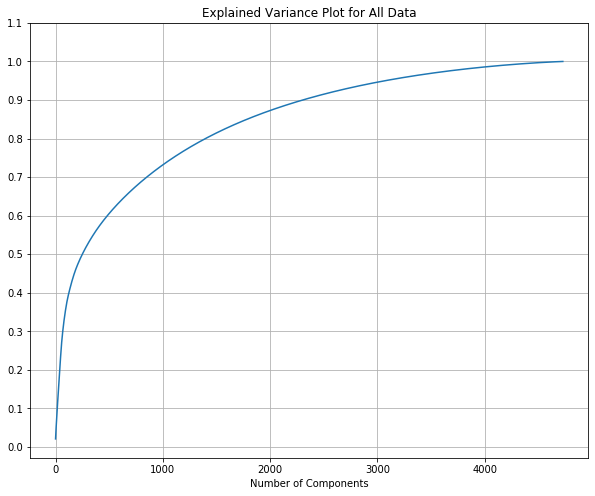

In [33]:
plt.figure(figsize=(10, 8))
plt.plot(ratios)
plt.title('Explained Variance Plot for All Data')
plt.xlabel('Number of Components')
plt.yticks(np.arange(0, 1.2, step=0.1))
plt.grid(True)
plt.show()

The plot of explained variance for both train and test data show that the first **3000** features account for 95% of the variance in both datasets. This will be information that I'll use in subsequent preprocessing efforts. 

### Distribution of Training Labels:

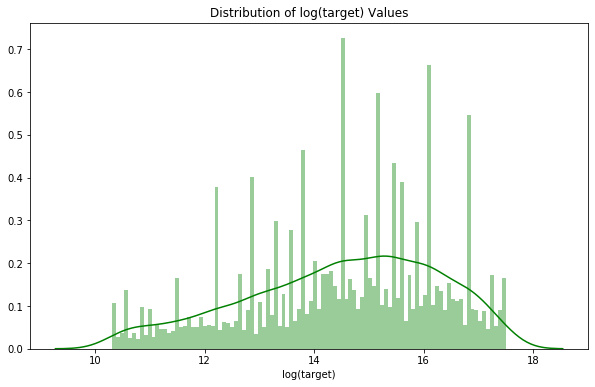

In [34]:
plt.figure(figsize=(10, 6))
sns.distplot(np.log1p(labels), color='green', kde=True, bins=100)
plt.title('Distribution of log(target) Values')
plt.xlabel('log(target)')
plt.show()